In [4]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from seaborn import despine
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model

# 1. Example 3: Classifying images

In this notebook, we will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

This dataset contains 28 x 28 pixel grey-scale images of clothing pieces.

Overall, the dataset contains 10 different categories of clothing.

We can load the dataset with the `fashion_mnist.load_data()` function from `tensorflow.keras.datasets`.

(More details on [Tensorflow](https://www.tensorflow.org) and [Keras](https://keras.io) will follow later).

In [2]:
# load Fashion MNIST data
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data() #datasets.cifar10.load_data()

# the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

This dataset is already divided into a training and test dataset, each containing 60000 and 10000 distinct grey scale images:

In [6]:
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

To make these images easily digestable for a neural network, we will normalize the range of the pixel values to a range between 0 and 1:

In [ ]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = np.expand_dims(train_images / 255.0, -1), np.expand_dims(test_images / 255.0, -1)

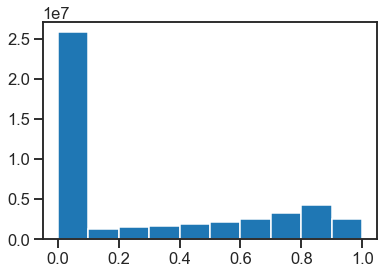

In [22]:
_ = plt.hist(train_images.ravel())

Ok, the normalization worked; The high frequency of 0 values is based on the consistent black background of each image

Let's take a look at a few of the training examples:

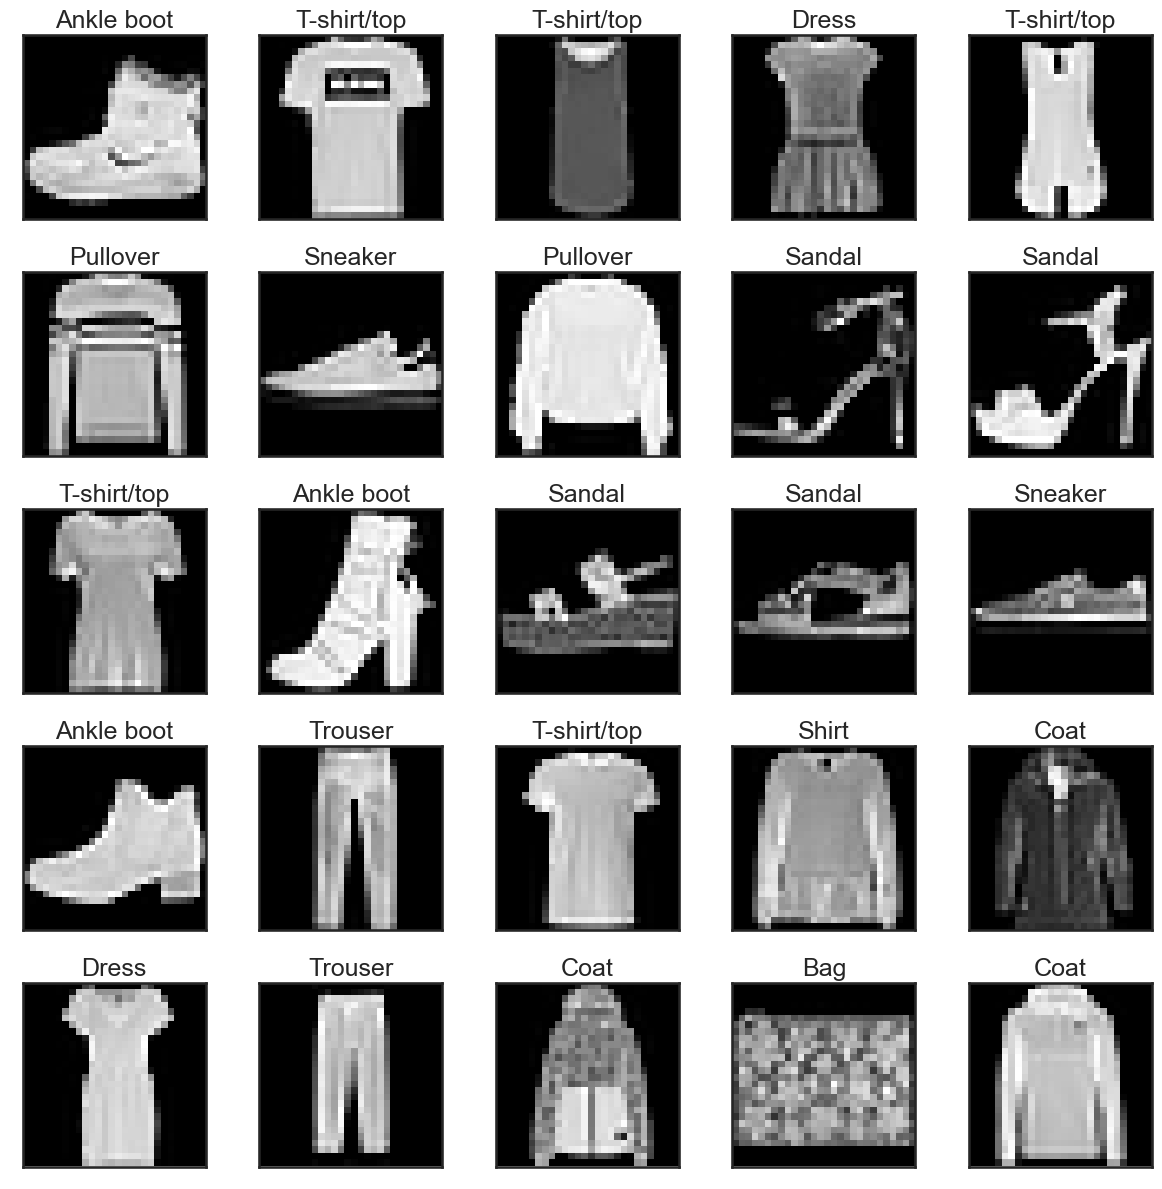

In [7]:
fig, axs = plt.subplots(5,5,figsize=(12,12), dpi=100)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.imshow(train_images[i,...,0], cmap='gray')
    ax.set_title(class_names[train_labels[i]])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('figures/Figure-2-0_Fashion-MNIST.png', dpi=600)

# 2. Convolutional Neural Networks

## 2.1 Biological inspiration

One way of classifying this dataset would be to flatten each sample to a vector of 784 values (28 x 28) and to feed it to a fully-connected artificial neural network (as we did with the hand-written digit data in the previous notebook (1-Neural-Networks-Backpropagation.ipynb)).

However, there is another common type of artificial neural networks that was specifically designed for computer vision problems. 

These networks are called *convolutional neural networks* and are (very) loosely inspired by our knowledge of the the neurobiological processes of human vision.

On a superficial level, the human brain processes visual information in the following steps (see also Figure below):

First, a projection of the image is registered on the retina. The retina is composed of various types of neurons, which are each sensitive to specific characteristics of the perceived image (each neuron has a receptive field, describing an area in the image for which it is sensitive).

These neurons are connected to the optical nerve and send their signals along the visual system of the brain.

The visual system itself is composed of multiple brain reqions (encompassing the [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex#Primary_visual_cortex_(V1)), which seem to respond to different characteristics of the perceived image.

Importantly, the complexity of these characteristics increases as you travel along the visual system, such that lower level regions are more sensitive to basic propoerties of the perceived image (such as orientatoin and contrast), while higher level regions respond to more complex stimuli (famous examples are the [fusiform face area](https://en.wikipedia.org/wiki/Fusiform_face_area) and [parahippocampal place area](https://en.wikipedia.org/wiki/Parahippocampal_gyrus) which specifically respond to faces and scenes).

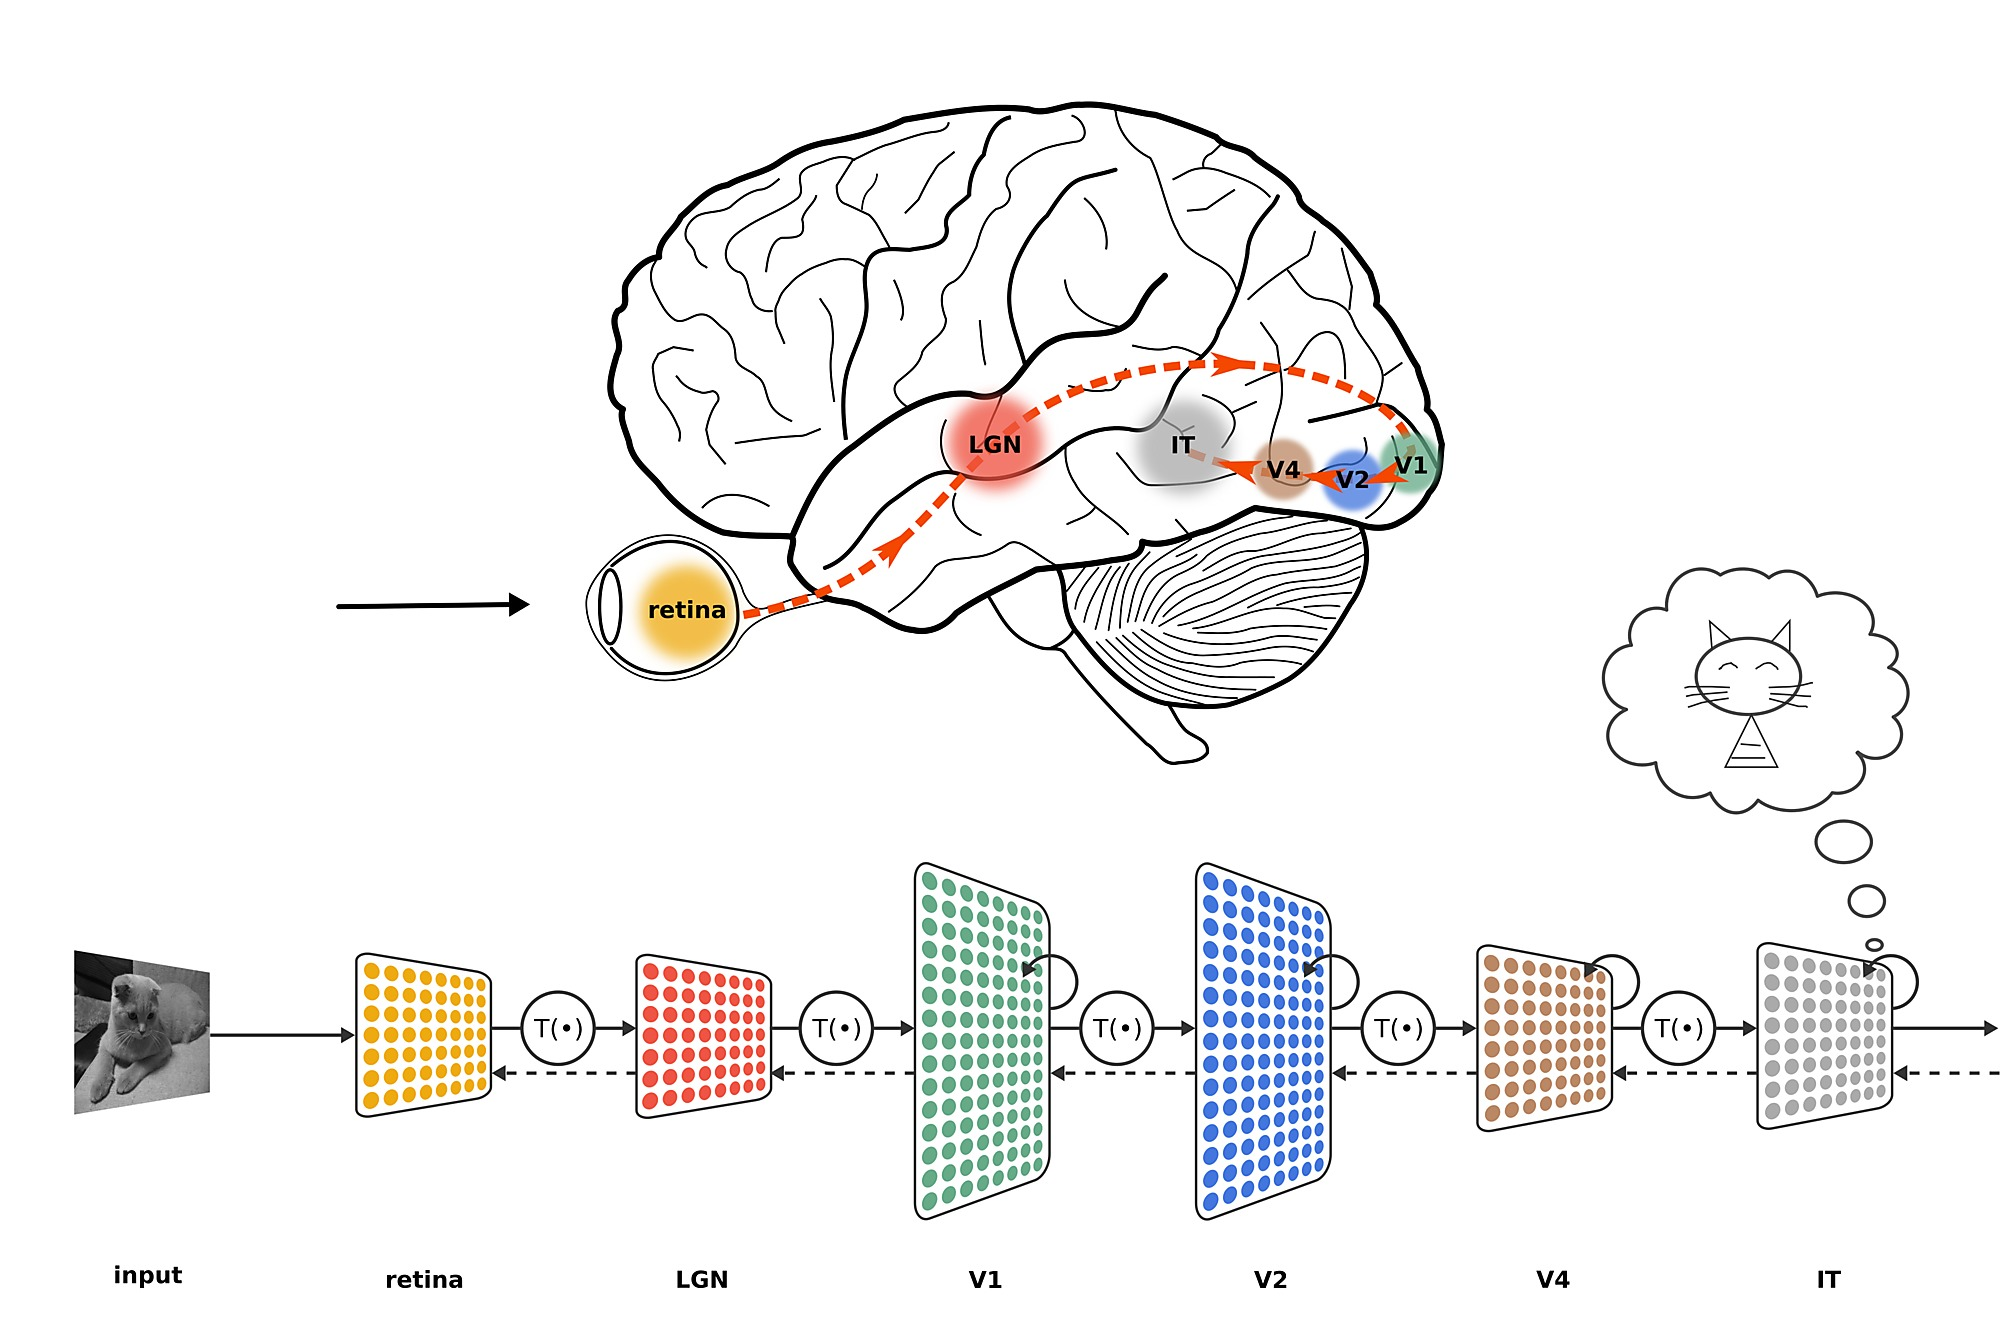

In [12]:
Image(filename='materials/images/free-use/Human-Vision.jpg')

*Adapted from:* Kubilius, Jonas (2017): Ventral visual stream. figshare. Figure. https://doi.org/10.6084/m9.figshare.106794.v3 

## 2.2. Convolution Kernels (or filters)

This idea of neurons that respond to specific elements of a visual input has been transferred to computer vision, by the use of convolution kernels (or filters).

Each kernel conceptually represents a neuron and is composed of a small square matrix (typically with a size 3x3 or 5x5 values).

To create an activation map with a kernel (indicating for each location of the image whether the element is present for which the kernel is sensitive), we perform a [convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)) between the kernel and image.

Computationally, this means nothing else than moving the kernel over the image. At each location, the values of the kernel are multiplied with the values of the image at this location and summed, resulting in a single value in the activation map (see below):

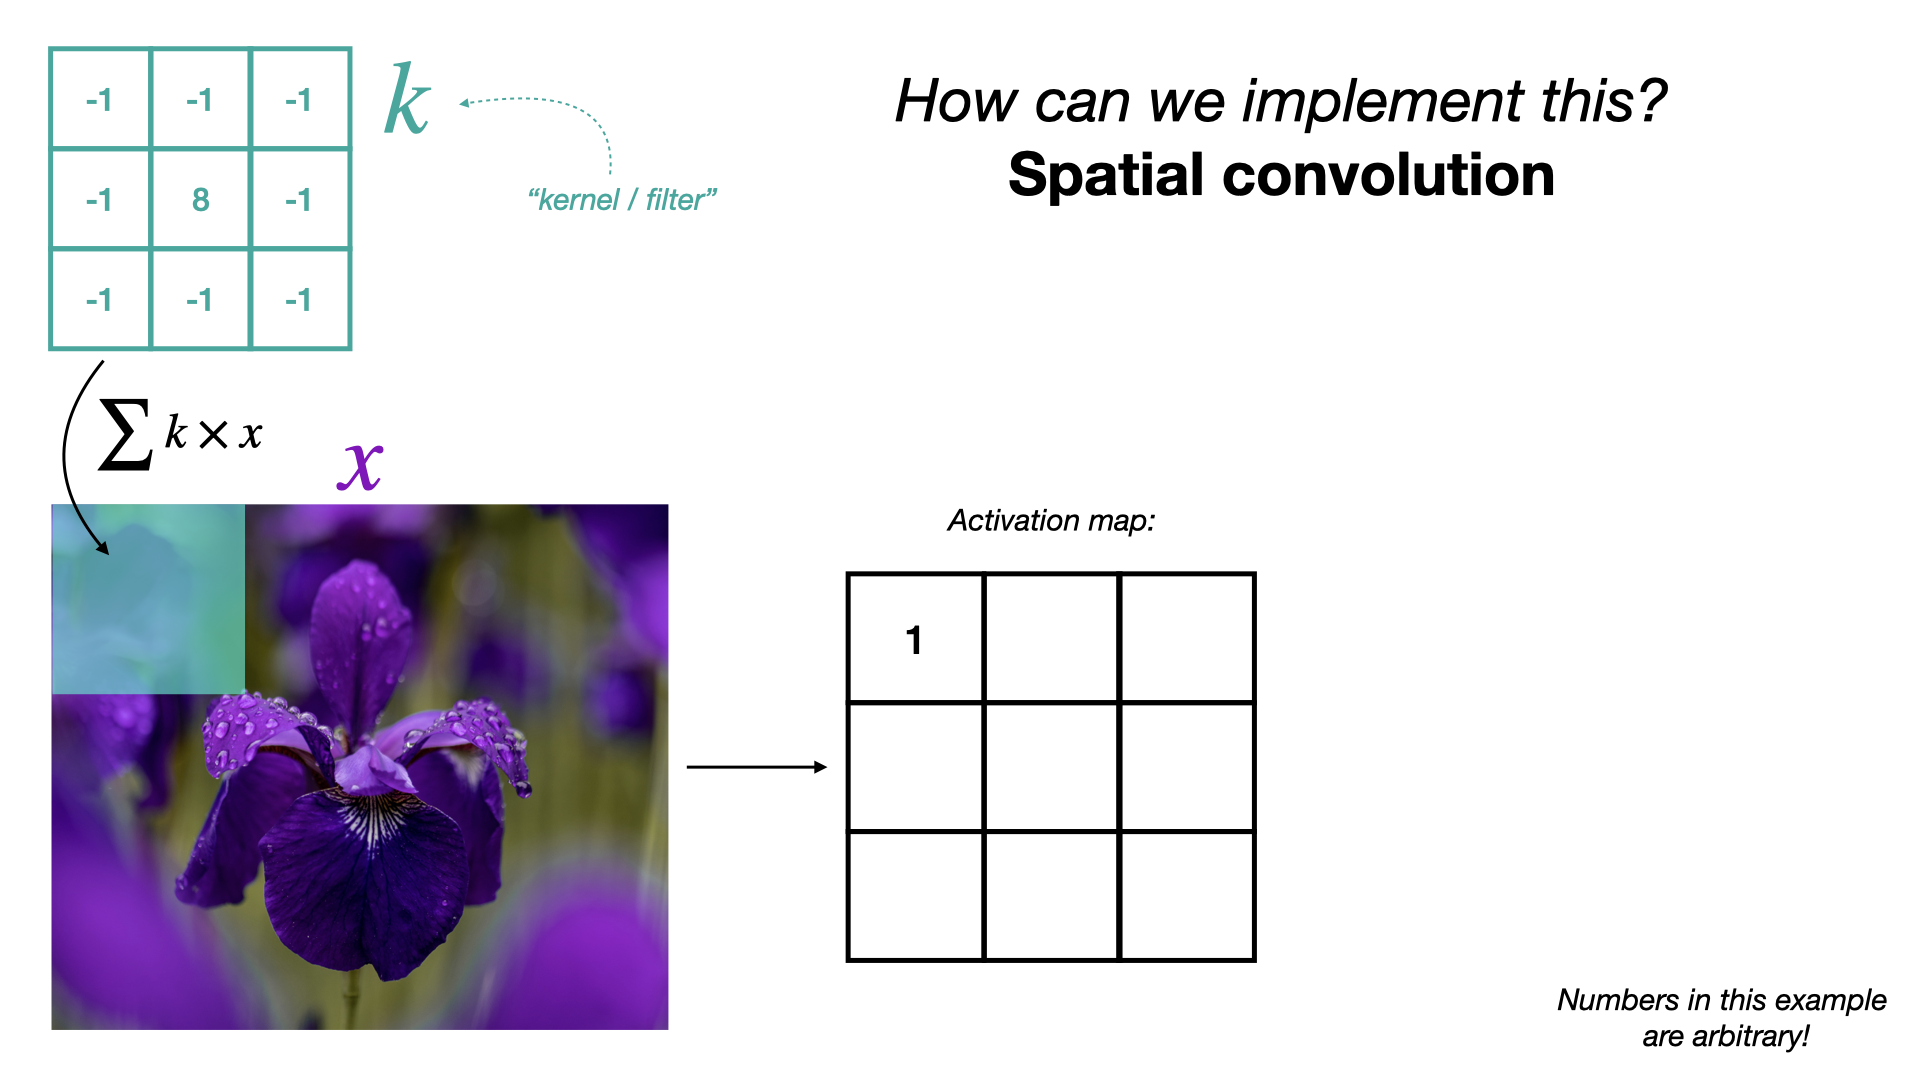

In [13]:
Image(filename='materials/images/free-use/Spatial-Convolution.png')

Importantly, the distance between the application of the kernel to the input image is called the *stride*. A stride of 1 pixel generally creates an activation map of the same size as the input image, while larger strides reduce the size of the activation map:

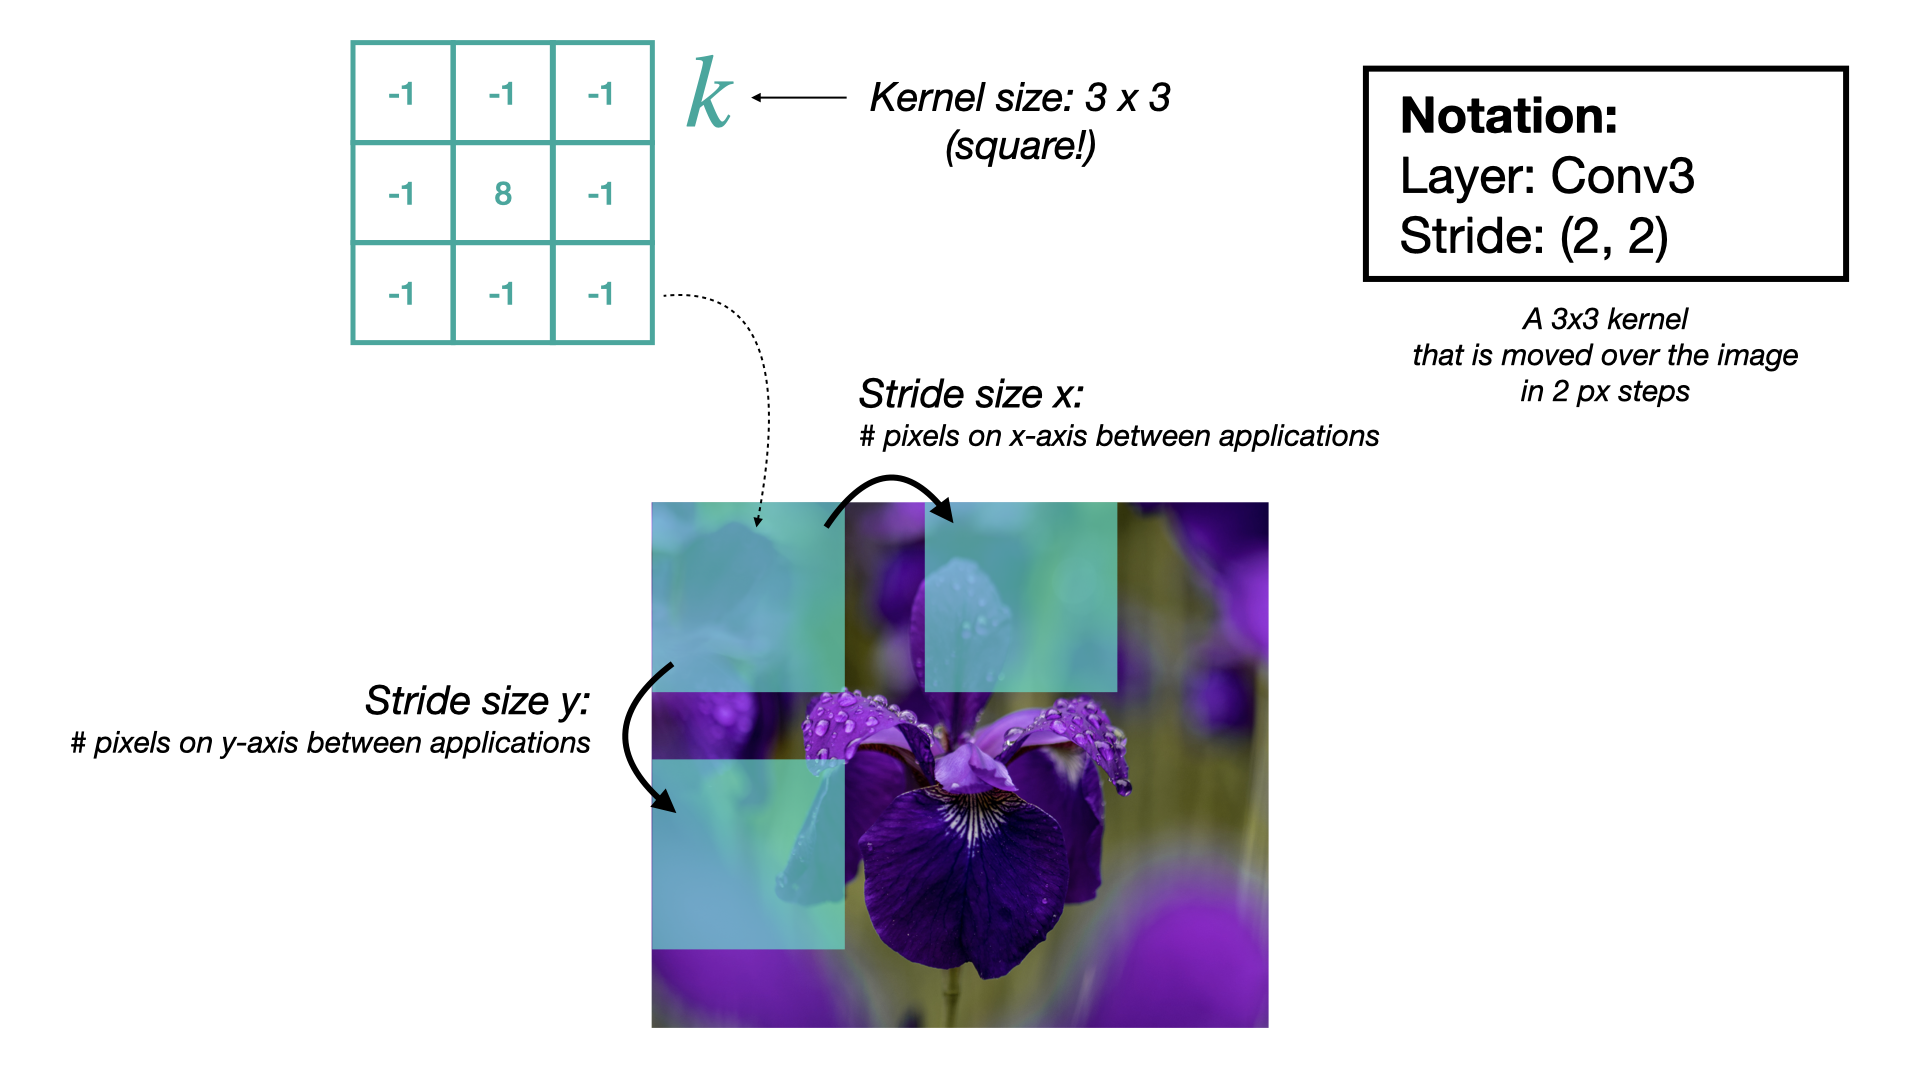

In [14]:
Image(filename='materials/images/free-use/Stride.png')

Let's try this ourselves with some data:

In [16]:
def spatial_convolution_2D(image, kernel, bias=0):
    """spatial 2D convolution between an image and 
    a kernel with stride size 1
    """
    m, n = kernel.shape[:2]
    if (m == n):
        yin, xin = image.shape[:2]
        yout = yin - m + 1
        xout = xin - m + 1
        convolved_image = np.zeros((yout,xout))
        for i in range(yout):
            for j in range(xout):
                convolved_image[i,j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return convolved_image

Here, we will be using a few exemplary edge detection kernels (based on the [Sobel Operator](https://en.wikipedia.org/wiki/Sobel_operator)):

In [17]:
# a kernel that is sensitive to vertical edges:

vertical_edge_kernel = np.zeros((3,3))
vertical_edge_kernel[:,0] = 1
vertical_edge_kernel[:,2] = -1
vertical_edge_kernel[1,0] = 2
vertical_edge_kernel[1,2] = -2
vertical_edge_kernel

array([[ 1.,  0., -1.],
       [ 2.,  0., -2.],
       [ 1.,  0., -1.]])

In [18]:
# a kernel that is sensitive to horizontal edges:

horizontal_edge_kernel = np.zeros((3,3))
horizontal_edge_kernel[0] = 1
horizontal_edge_kernel[2] = -1
horizontal_edge_kernel[0,1] = 2
horizontal_edge_kernel[2,1] = -2
horizontal_edge_kernel

array([[ 1.,  2.,  1.],
       [ 0.,  0.,  0.],
       [-1., -2., -1.]])

In [19]:
# a kernel that is sensitive to all edges:

edge_detection_kernel = -1.0 * np.ones((3,3))
edge_detection_kernel[1,1] = 8
edge_detection_kernel

array([[-1., -1., -1.],
       [-1.,  8., -1.],
       [-1., -1., -1.]])

So what kind of activation maps do we get when we convolve these three kernels with a few examples of our dataset?

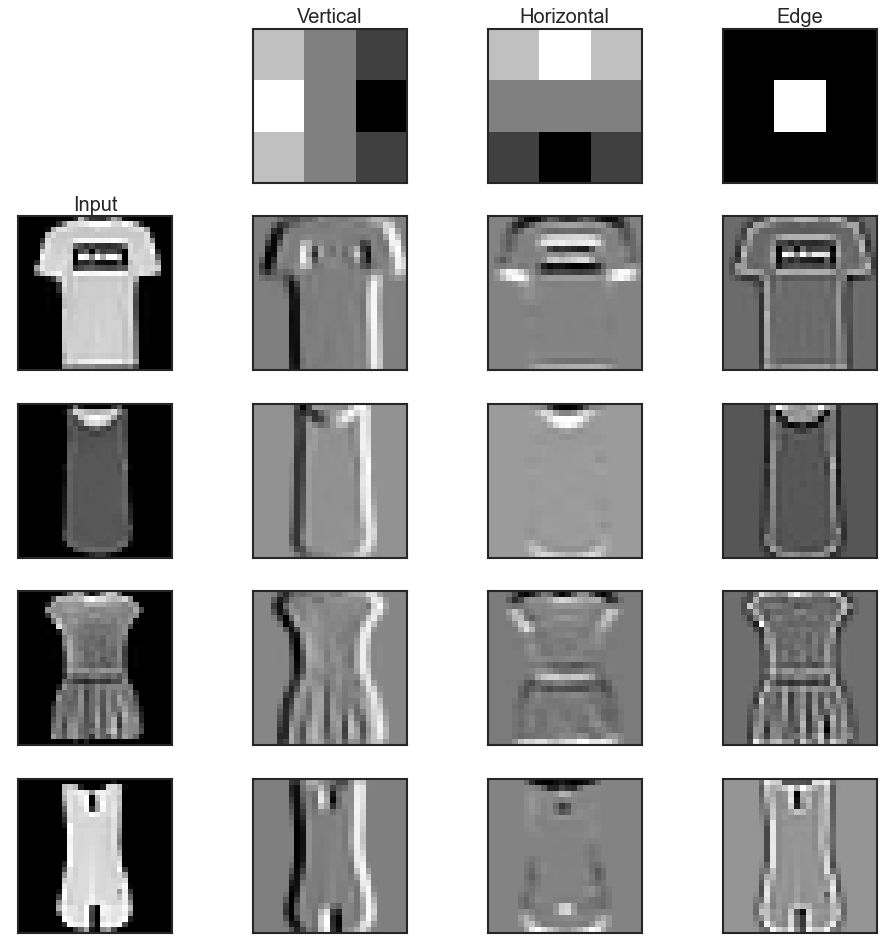

In [20]:
fig, axs = plt.subplots(5,4,figsize=(12,12), dpi=80)
axs[0,0].remove()

# plot kernels
axs[0,1].imshow(vertical_edge_kernel, cmap='gray')
axs[0,2].imshow(horizontal_edge_kernel, cmap='gray')
axs[0,3].imshow(edge_detection_kernel, cmap='gray') 

# plot activation maps
for i in range(1,5):
    
    # input image
    axs[i,0].imshow(train_images[i,...,0], cmap='gray')

    # vertical
    convolved_img = spatial_convolution_2D(train_images[i,...,0], vertical_edge_kernel)
    axs[i,1].imshow(convolved_img, cmap='gray')
    
    # horizontal
    convolved_img = spatial_convolution_2D(train_images[i,...,0], horizontal_edge_kernel)
    axs[i,2].imshow(convolved_img, cmap='gray')
    
    # edge
    convolved_img = spatial_convolution_2D(train_images[i,...,0], edge_detection_kernel)
    axs[i,3].imshow(convolved_img, cmap='gray')

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

# label axes
axs[1,0].set_title('Input')
axs[0,1].set_title('Vertical')
axs[0,2].set_title('Horizontal')
axs[0,3].set_title('Edge')

# save
fig.tight_layout()
fig.savefig('figures/Figure-2-1_Edge-Detection-Kernels.png', dpi=600)

As expected, the activation maps resulting from the spatial convolution highlight the characteristics of the image that each kernel is sensitive to: vertical edges, horizontal edges, all edges!

## 2.3 Stacking many kernels to a convolutional neural network



A convolutional neural network is nothing more than a sequence of convolution layers, which are each composed of a stack of convolution kernels!

Importantly, the kernels of each layer are applied to the activation maps resulting from the previous layer. This trick allows higher-level convolution kernels (which are deeper into the network) to learn very abstracted features, based on the activation maps of the lower-level convolution kernels (more about this later).

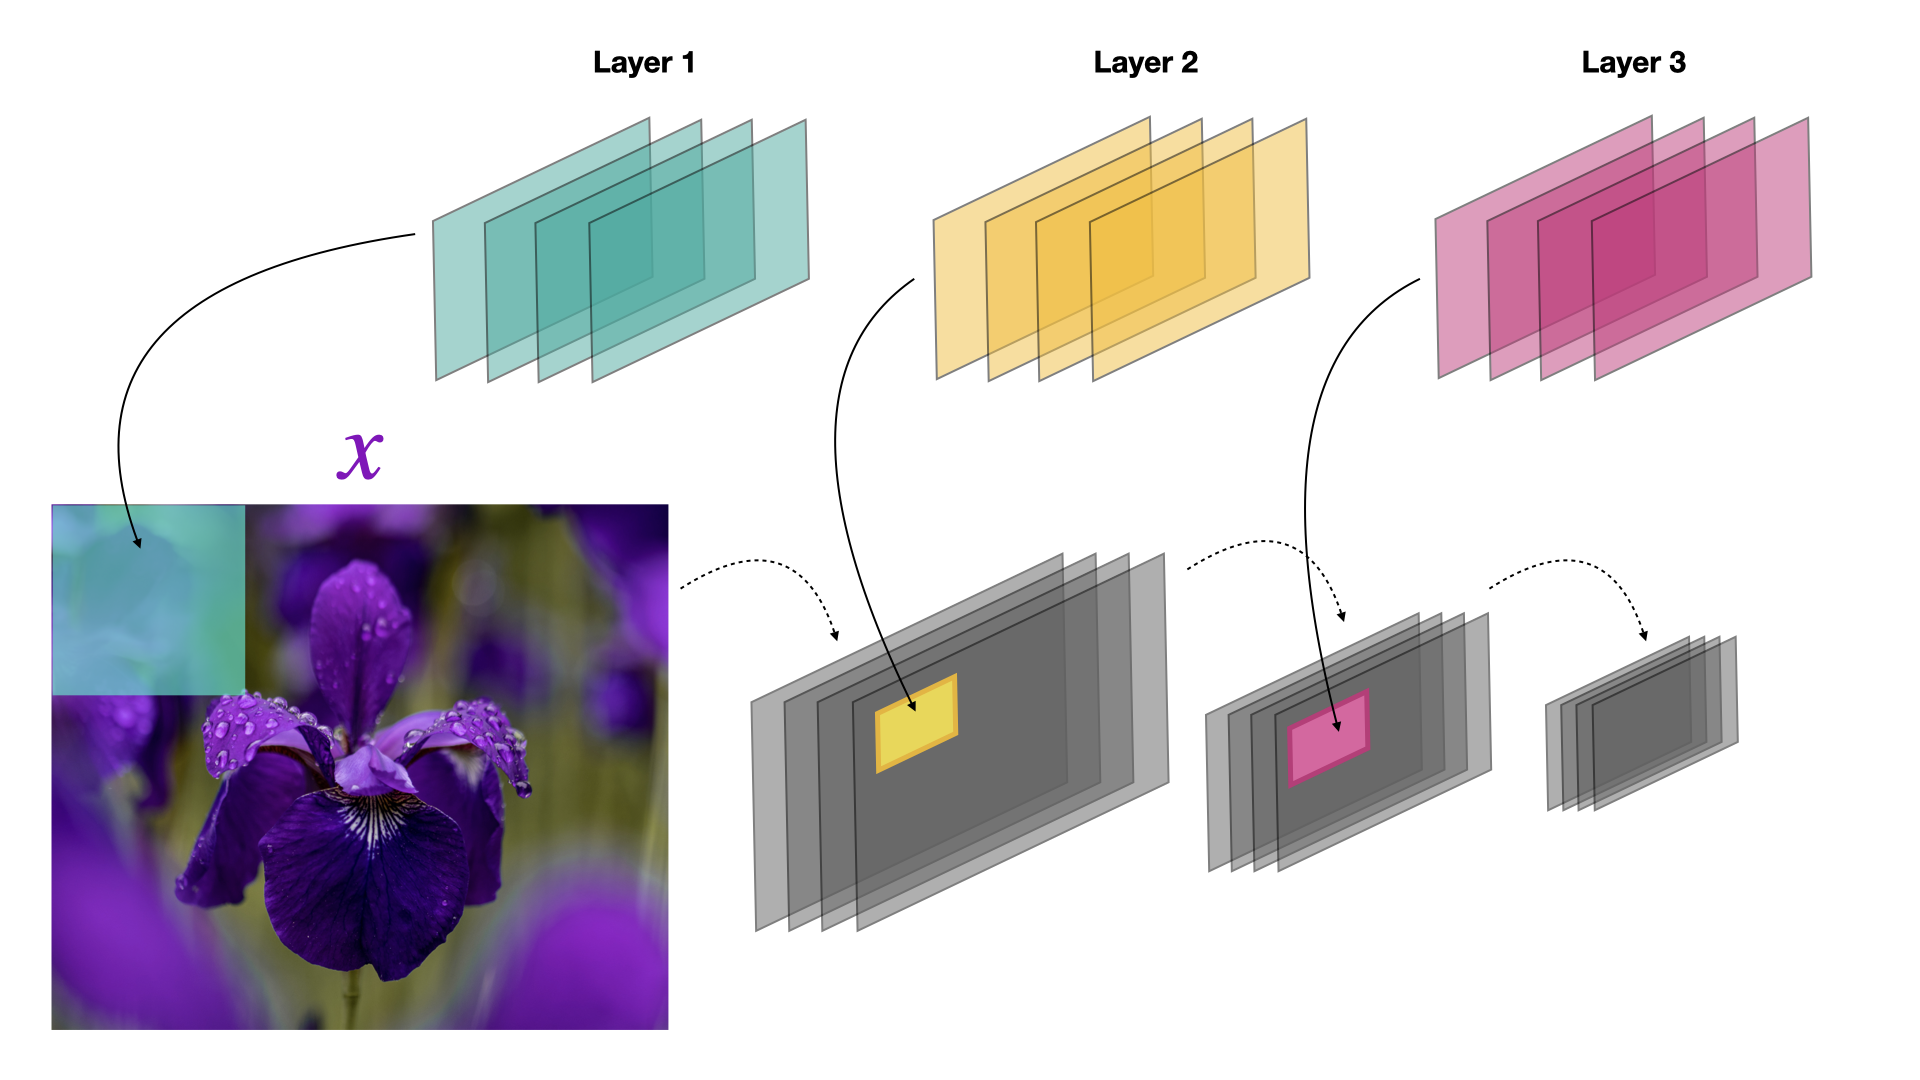

In [23]:
Image(filename='materials/images/free-use/Convolutional-Neural-Network.png')

## 2.4 Pooling kernels

Classical CNN architectures contain one more type of kernel, which is used to decrease the size of the activation maps (ie., to down-sample the image).

These kernels are called *pooling kernels*.

Two classical pooling kernels are *average* and *max* pooling.

These do nothing else then return the average or max value over their receptive field.

Importantly, they are moved over the image in non-overlapping steps: A pooling kernel of size 2x2 would therefor be moved over the image in 2 pixel steps, thereby down-sampling its input by a factor of 2:

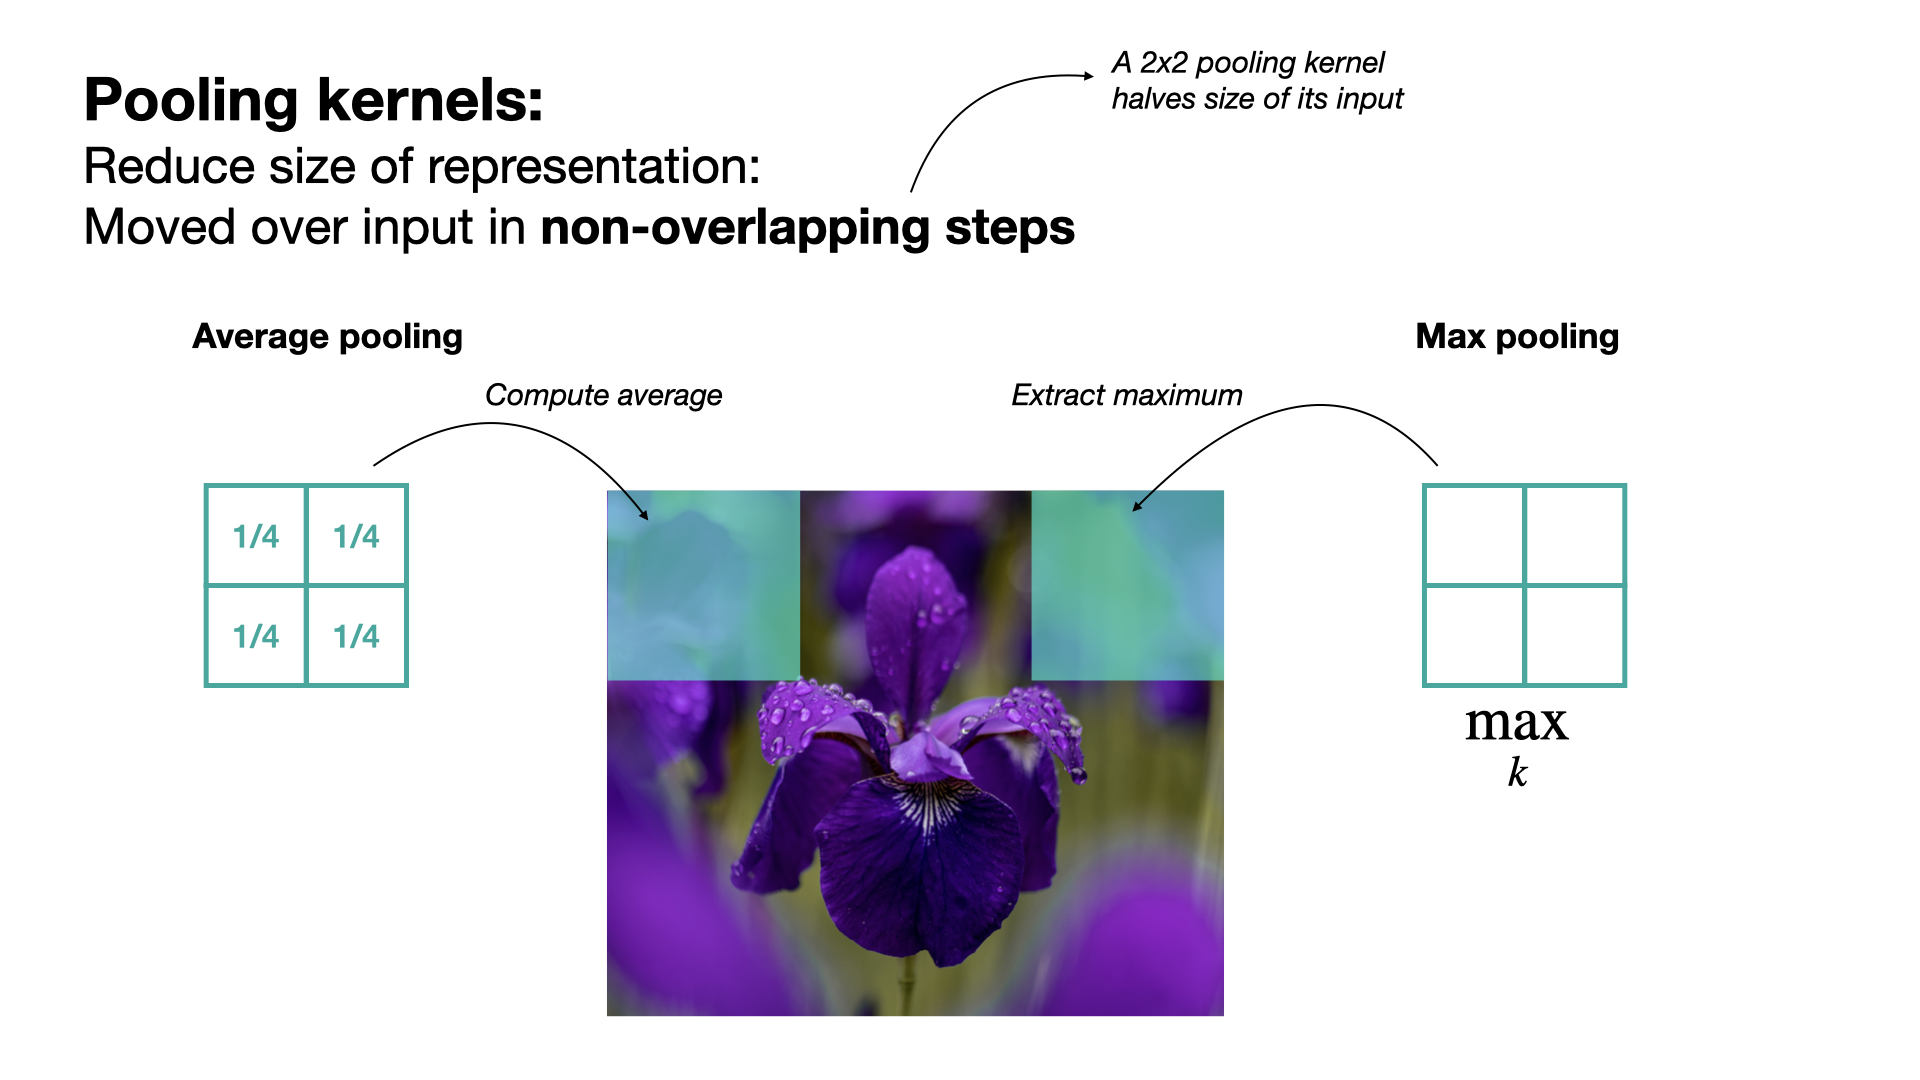

In [24]:
Image(filename='materials/images/free-use/Pooling-Kernels.png')

## 2.4 Building a convolutional neural network in Tensorflow

In [10]:
model = models.Sequential()

# convolution layers
model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.AveragePooling2D())      
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.AveragePooling2D()) 
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

# dense output layers
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        592       
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                9

# Fitting

In [12]:
model.compile(optimizer='rmsprop',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
np.random.seed(1421)
tf.random.set_seed(1421)
history = model.fit(train_images,
                    train_labels,
                    epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6843 - accuracy: 0.7458 - val_loss: 0.5155 - val_accuracy: 0.8097
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4575 - accuracy: 0.8310 - val_loss: 0.4384 - val_accuracy: 0.8429
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3941 - accuracy: 0.8550 - val_loss: 0.4074 - val_accuracy: 0.8444
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3618 - accuracy: 0.8678 - val_loss: 0.3629 - val_accuracy: 0.8684
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3389 - accuracy: 0.8765 - val_loss: 0.3875 - val_accuracy: 0.8594
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3219 - accuracy: 0.8824 - val_loss: 0.3508 - val_accuracy: 0.8707
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3100 - accuracy: 0.8871 - val_loss: 0.3341 - val_accurac

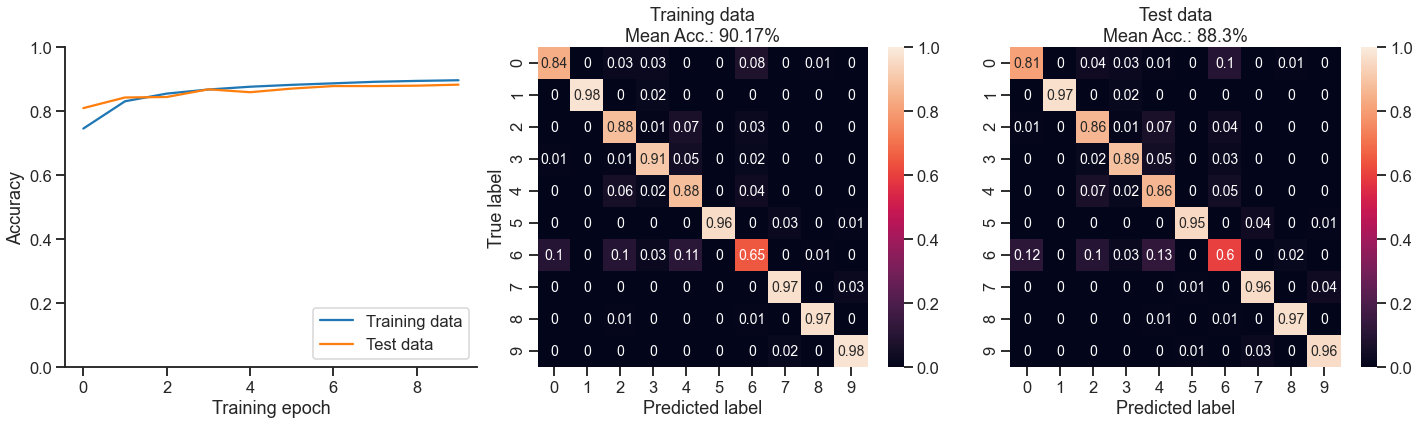

In [35]:
fig, axs = plt.subplots(1,3,figsize=(20,6))

axs[0].plot(history.history['accuracy'], label='Training data')
axs[0].plot(history.history['val_accuracy'], label = 'Test data')
axs[0].set_xlabel('Training epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='lower right')
despine(ax=axs[0])

# plot confusion matrix for training and test data
for i, (label, X, y) in enumerate(zip(['Training', 'Test'],
                                   [train_images, test_images],
                                   [train_labels, test_labels])):
    y_pred = model.predict(X).argmax(axis=1)
    acc = np.mean(y_pred == y)
    axs[1+i].set_title('{} data\nMean Acc.: {}%'.format(label, np.round(acc*100, 2)))
    conf_mat = confusion_matrix(y, y_pred, normalize='true')
    sns.heatmap(np.round(conf_mat, 2), annot=True,
                ax=axs[1+i], vmin=0, vmax=1,
                annot_kws={'fontsize': 14})
    if i == 0:
        axs[1+i].set_ylabel('True label')
    axs[1+i].set_xlabel('Predicted label')

fig.tight_layout()
fig.savefig('figrues/Figure-2-2_Training-Stats.png', dpi=600)

In [15]:
first_layer_weights = model.get_weights()[0]
first_layer_weights.shape

(3, 3, 1, 4)

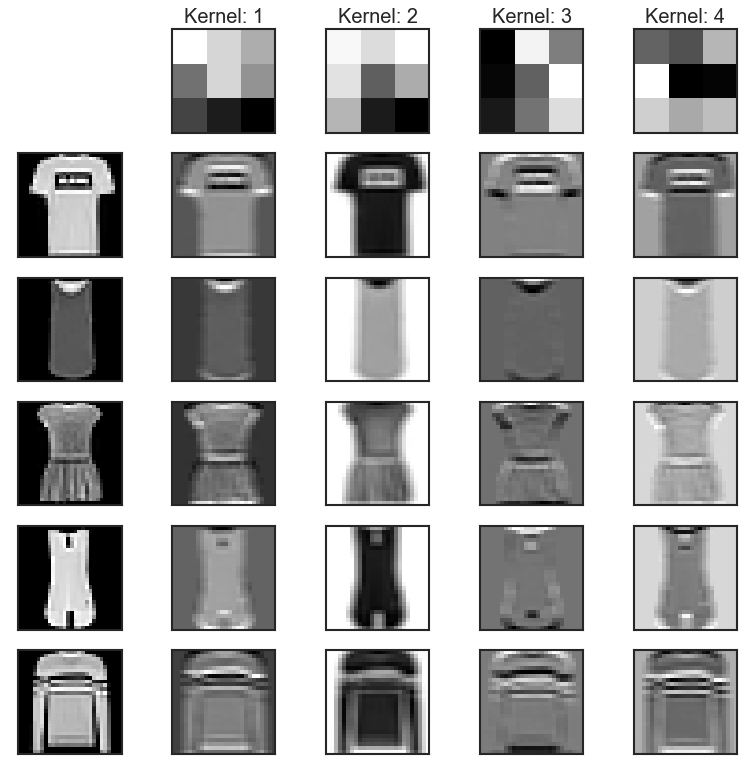

In [16]:
fig, axs = plt.subplots(6,first_layer_weights.shape[-1]+1,figsize=(12,12), dpi=80)

for j in range(first_layer_weights.shape[-1]):
    axs[0,j+1].imshow(first_layer_weights[:,:,0,j], cmap='gray')
    axs[0,j+1].set_title('Kernel: {}'.format(j+1))
axs[0,0].remove()

for i in range(1,6):
    axs[i,0].imshow(train_images[i,...,0], cmap='gray')
    for j in range(first_layer_weights.shape[-1]):
        convolved_img = spatial_convolution_2D(train_images[i,...,0], first_layer_weights[...,j])
        axs[i,j+1].imshow(convolved_img, cmap='gray')

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
fig.savefig('figures/Figure-2-3_Learned-Activation-Maps.png', dpi=600)

# Exersice

# Activation Maximization

For this analysis, we use the [VGG16](https://arxiv.org/abs/1409.1556) architecture, which was pre-trained in on the [ImageNet](http://www.image-net.org) dataset. 

In [17]:
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [18]:
from deep_dream import run_deep_dream

Processing layer: block1_conv1, kernel: 0
Processing layer: block1_conv1, kernel: 10
Processing layer: block1_conv1, kernel: 35
Processing layer: block2_conv2, kernel: 0
Processing layer: block2_conv2, kernel: 10
Processing layer: block2_conv2, kernel: 35
Processing layer: block3_conv3, kernel: 0
Processing layer: block3_conv3, kernel: 10
Processing layer: block3_conv3, kernel: 35
Processing layer: block4_conv3, kernel: 0
Processing layer: block4_conv3, kernel: 10
Processing layer: block4_conv3, kernel: 35


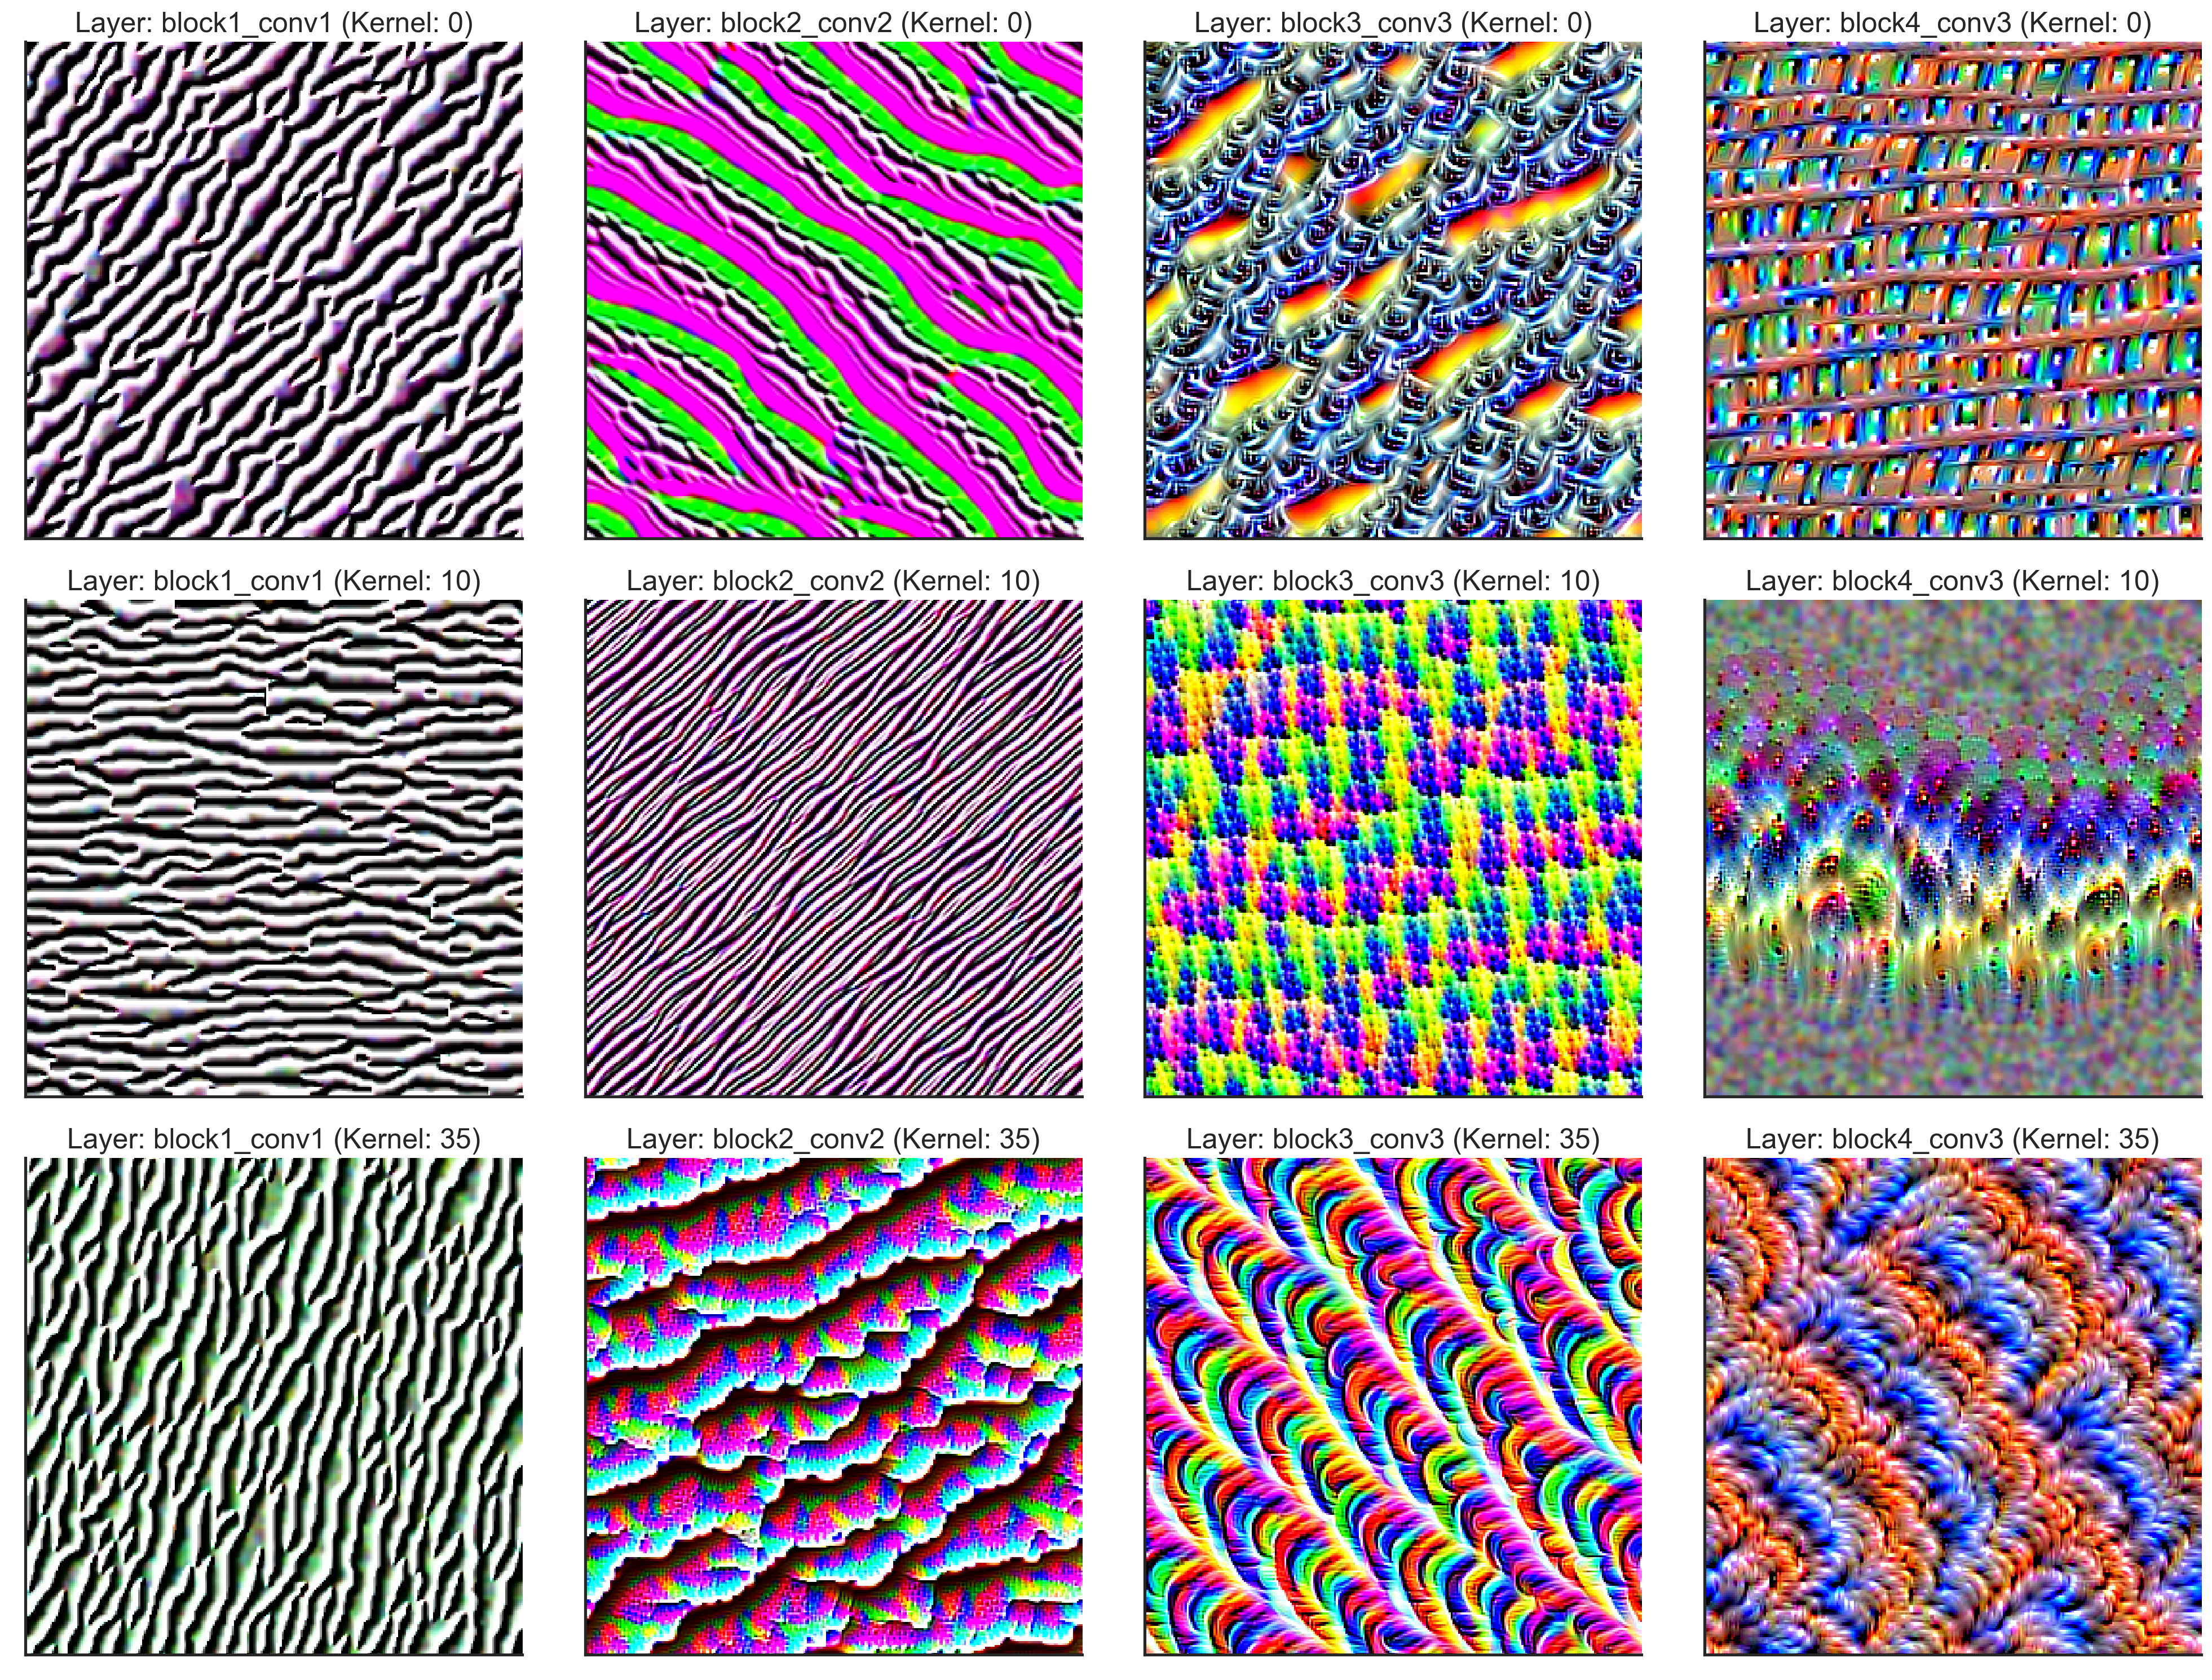

In [36]:
np.random.seed(2135)
tf.random.set_seed(2135)

fig, axs = plt.subplots(3,4,figsize=(20,15), dpi=200)

# define random input image
random_input = np.random.uniform(0,255,(200,200,3)).astype(np.int)

# iterate three layers from VGG16
for i, layer_name in enumerate(['block1_conv1', 'block2_conv2', 'block3_conv3', 'block4_conv3']):
    
    # Create the feature extraction model
    layer_output = vgg16.get_layer(layer_name).output
    for j, k in enumerate([0,10,35]):
        print('Processing layer: {}, kernel: {}'.format(layer_name, k))
        dream_model = tf.keras.Model(inputs=vgg16.input,
                                     outputs=layer_output[...,k])

        # run deep dream
        img = run_deep_dream(dream_model, random_input,
                             show_progress=False)

        # plot
        axs[j,i].imshow(img.numpy())
        axs[j,i].set_title('Layer: {} (Kernel: {})'.format(layer_name, k))
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])
        despine(ax=axs[j,i])
    
fig.tight_layout()
fig.savefig('figures/Figure-2-4_VGG16-Deep-Dream.png', dpi=600)

# look at this: https://distill.pub/2018/building-blocks/